# Read image by reference

In this example we want to create an instance of ADsimdetector using Ophyd async and then read the last element from Tiled and display the image, which was saved. 

We create the instance of RunEngine and subscribe the callback to the RunEngine.

In [1]:
from bluesky.run_engine import RunEngine, autoawait_in_bluesky_event_loop

RE = RunEngine({})

def print_docs_to_stdout(name, doc):
    print(f"----------- {name} --------------")
    print(f"{doc = }")
    print(f"-------------------------\n")

RE.subscribe(print_docs_to_stdout)

0

As we want to write to Tiled, we need to connect the callback to the tiled instance. 

In [2]:
from tiled.client import from_uri
from bluesky.callbacks.tiled_writer import TiledWriter

tiled_client = from_uri("http://127.0.0.1:8000", api_key="secret", include_data_sources=True)
tw = TiledWriter(tiled_client)
RE.subscribe(tw)
autoawait_in_bluesky_event_loop()

Before initializing the ADsim detector, we need to specify path and filename for images.

In this case we will use:

- **UUIDFilenameProvider** → A callable that generates unique filenames using UUIDs.  
- **YMDPathProvider** → A callable that returns a file path structured by Year/Month/Day, using a filename provider.

In [3]:
from ophyd_async.core import init_devices, UUIDFilenameProvider, YMDPathProvider

fp = UUIDFilenameProvider()
pp = YMDPathProvider(fp, "/home/epics/images", create_dir_depth=-10)

In the next step, we will initialize the Adsimdetector and pass the path provider.

In [4]:
from ophyd_async.epics import adsimdetector

with init_devices():
    sim_cam = adsimdetector.SimDetector("13SIM1:", pp, name="sim_cam")

Before recording the images we need to prime the HDF5 plugin that will be used to save images.

In [5]:
await sim_cam.trigger()

Let's collect an image and investigate the content of the documents.

In [6]:
from bluesky.plans import count
RE(count([sim_cam]))

----------- start --------------
doc = {'uid': 'e2469145-37f1-4970-b51d-102628f936d1', 'time': 1740424316.5307016, 'versions': {'ophyd': '1.10.0', 'bluesky': '1.13.1rc3.dev4+gea61fb99'}, 'scan_id': 1, 'plan_type': 'generator', 'plan_name': 'count', 'detectors': ['sim_cam'], 'num_points': 1, 'num_intervals': 0, 'plan_args': {'detectors': ['<ophyd_async.epics.adsimdetector._sim.SimDetector object at 0x740266117450>'], 'num': 1, 'delay': 0.0}, 'hints': {'dimensions': [(('time',), 'primary')]}}
-------------------------

----------- descriptor --------------
doc = {'configuration': {'sim_cam': {'data': {'sim_cam-driver-acquire_period': 0.005, 'sim_cam-driver-acquire_time': 0.001}, 'timestamps': {'sim_cam-driver-acquire_period': 1740424050.157216, 'sim_cam-driver-acquire_time': 1740424050.157131}, 'data_keys': {'sim_cam-driver-acquire_period': {'dtype': 'number', 'shape': [], 'dtype_numpy': '<f8', 'source': 'ca://13SIM1:cam1:AcquirePeriod_RBV', 'units': '', 'precision': 3}, 'sim_cam-driver-

('e2469145-37f1-4970-b51d-102628f936d1',)

Let's check the content that is available in Tiled.

In [15]:
runs = tiled_client.values()
list(runs)

[<Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {'primary'}>,
 <Container {}>,
 <Container {'primary'}>,
 <Container {'primary'}>]

In [16]:
last_run = runs[-1]

In [17]:
last_run['primary']['external']['sim_cam'].data_sources()

[DataSource(structure_family='array', structure={'data_type': {'endianness': 'not_applicable', 'kind': 'u', 'itemsize': 1, 'dt_units': None}, 'chunks': [[1], [1024], [1024]], 'shape': [1, 1024, 1024], 'dims': None, 'resizable': False}, id=87, mimetype='application/x-hdf5', parameters={'dataset': ['entry', 'data', 'data'], 'swmr': False}, assets=[Asset(data_uri='file://localhost/home/epics/images/sim_cam/2025/02/24/7c17a759-669b-4158-8de0-436b1baddfd4.h5', is_directory=False, parameter='data_uri', num=None, id=87)], management='external')]

In [18]:
last_run['primary']['config']['sim_cam'].read()

descriptor_uid  sim_cam-driver-acquire_period  \
0  16a9cf55-e81b-4755-be65-08cc9057652d                          0.005   

   sim_cam-driver-acquire_time  ts_sim_cam-driver-acquire_period  \
0                        0.001                      1.740424e+09   

   ts_sim_cam-driver-acquire_time  
0                    1.740424e+09

In [19]:
import matplotlib.pyplot as plt

arr = tiled_client.values().last()['primary']['external']['sim_cam'].read()
img = arr[0]

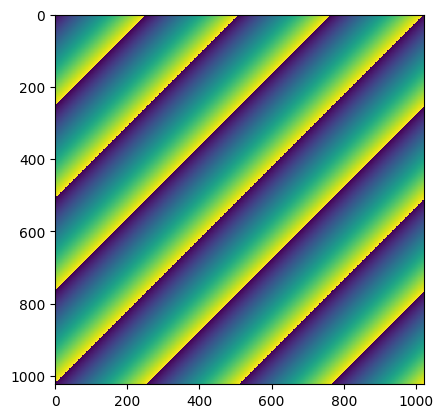

In [20]:
plt.imshow(img, cmap='viridis',interpolation='nearest')